# Env Setup

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langsmith

In [ ]:
import getpass
import os


def _set_env(var: str):
        #if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


# Response Streaming


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    return ["Cloudy with a chance of hail."]


tools = [search]

In [ ]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

In [ ]:
model = model.bind_tools(tools)

In [ ]:
from typing import Literal

from langchain_core.runnables import RunnableConfig

from langgraph.graph import END, START, StateGraph


# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["__end__", "tools"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # Otherwise if there is, we continue
    else:
        return "tools"


# Define the function that calls the model
async def call_model(state: State, config: RunnableConfig):
    messages = state["messages"]
    response = await model.ainvoke(messages, config)
    # We return a list, because this will get added to the existing list
    return {"messages": response}

In [ ]:
# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

workflow.add_edge("tools", "agent")

app = workflow.compile()

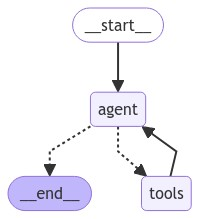

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
import time
start_time = time.time()
full_message = ""
inputs = [HumanMessage(content="What is the current weather in bangladesh")]
async for event in app.astream_events({"messages": inputs}, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI or Anthropic usually means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            now_time = time.time() - start_time
            full_message += content
            if len(full_message) > 20:
              print(content, end="")
            else:
              print(content+f" \033[91m{now_time:.3f}\033[0m", end="")
            #print(content+f" {now_time}", end="|")
            start_time = time.time()
    elif kind == "on_tool_start":
        print("--")
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
    elif kind == "on_tool_end":
        print(f"Done tool: {event['name']}")
        print(f"Tool output was: {event['data'].get('output')}")
        print("--")

--
Starting tool: search with inputs: {'query': 'current weather in Bangladesh'}
Done tool: search
Tool output was: content=['Cloudy with a chance of hail.'] name='search' tool_call_id='call_yx2O7T4Txmft249UJUa0p3fv'
--
The 1.057 current 0.023 weather 0.003 in Bangladesh is cloudy with a chance of hail.

# Tool Streaming

In [ ]:
from langchain_core.callbacks import Callbacks
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool

from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

In [ ]:
@tool
async def register_internet_problem(
    time: str, callbacks: Callbacks
) -> str:  # <--- Accept callbacks (Python <= 3.10)
    """Use this tool to register internet problem of the human."""
    template = ChatPromptTemplate.from_messages(
        [
            (
                "human",
                "I am facing internet problem since morning'. "
                "Register the internet problem..",
            )
        ]
    )
    chain = template | llm.with_config(
        {
            "run_name": "register internet problem LLM",
            "tags": ["tool_llm"],
            "callbacks": callbacks,  # <-- Propagate callbacks (Python <= 3.10)
        }
    )
    chunks = [chunk async for chunk in chain.astream({"time": time})]
    return "".join(chunk.content for chunk in chunks)

In [ ]:
llm = ChatOpenAI(model_name="gpt-4o")
tools = [register_internet_problem]
agent = create_react_agent(llm, tools=tools)

In [ ]:
import time

st_time = time.time()
now_time = st_time
async for event in agent.astream_events(
    {"messages": [("human", "I am facing internet problem since last night")]}, version="v2"
):
    tags = event.get("tags", [])
    # print(event["event"])
    if event["event"] == "on_chat_model_stream" and "tool_llm" in tags:
        print(event["data"]["chunk"].content, f"{(time.time()- now_time):.3f}", end="|", flush=True)
        now = time.time()

 1.984|I'm 0.004| sorry 0.012| to 0.003| hear 0.035| that 0.004| you're 0.020| experiencing 0.002| internet 0.003| issues 0.024|. 0.003| To 0.016| help 0.003| you 0.020| register 0.005| the 0.017| problem 0.003|, 0.053| I'll 0.002| need 0.021| a 0.002| few 0.003| details 0.004|:

 0.045|1 0.004|. 0.018| ** 0.003|Your 0.006| Internet 0.004| Service 0.004| Provider 0.017| ( 0.002|ISP 0.006|) 0.003| name 0.048|** 0.004|:
 0.056|2 0.003|. 0.004| ** 0.005|Your 0.007| account 0.003| number 0.004| or 0.007| customer 0.009| ID 0.006|** 0.005| ( 0.003|if 0.004| available 0.003|):
 0.003|3 0.016|. 0.004| ** 0.021|A 0.003| brief 0.018| description 0.004| of 0.033| the 0.004| problem 0.006|** 0.005| ( 0.022|e 0.004|.g 0.012|., 0.003| no 0.018| connection 0.004|, 0.015| slow 0.003| speeds 0.050|, 0.005| intermittent 0.005| connectivity 0.003|):
 0.005|4 0.006|. 0.037| ** 0.005|Your 0.005| contact 0.003| information 0.005|** 0.003| ( 0.017|phone 0.005| number 0.013| or 0.004| email 0.019|):
 0.004|5

In [ ]:
final_messages = event["data"]["output"]["messages"]

In [ ]:
for message in final_messages:
    message.pretty_print()

hello
================================ Human Message =================================

I am facing internet problem since last night
hello
================================== Ai Message ==================================
Tool Calls:
  register_internet_problem (call_8cHiQbOhzgWWjaeAP1LjYZyk)
 Call ID: call_8cHiQbOhzgWWjaeAP1LjYZyk
  Args:
    time: last night
hello
================================= Tool Message =================================
Name: register_internet_problem

I'm sorry to hear that you're experiencing internet issues. To help you register the problem, I'll need a few details:

1. **Your Internet Service Provider (ISP) name**:
2. **Your account number or customer ID** (if available):
3. **A brief description of the problem** (e.g., no connection, slow speeds, intermittent connectivity):
4. **Your contact information** (phone number or email):
5. **Your address** (if needed for service verification):

Once you provide this information, you can contact your ISP's custome

# Both streaming


In [ ]:

from langchain_core.callbacks import Callbacks
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool

from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
@tool
async def register_internet_problem(
    time: str, callbacks: Callbacks
) -> str:
    """Use this tool to register internet problem of the human."""
    template = ChatPromptTemplate.from_messages(
        [
            (
                "human",
                "I am facing internet problem since morning'. "
                "Register the internet problem..",
            )
        ]
    )
    chain = template | llm.with_config(
        {
            "run_name": "register internet problem LLM",
            "tags": ["tool_llm"],
            "callbacks": callbacks,
        }
    )
    chunks = [chunk async for chunk in chain.astream({"time": time})]
    return "".join(chunk.content for chunk in chunks)



@tool
async def register_indoor_coverage_problem(
    place: str, callbacks: Callbacks
) -> str:
    """Use this tool to register indoor coverage problem of the human."""
    template = ChatPromptTemplate.from_messages(
        [
            (
                "human",
                "I am facing indoor coverage problem since morning. I live in mirpur 10 dhaka. "
                "Register the internet problem..",
            )
        ]
    )
    chain = template | llm.with_config(
        {
            "run_name": "register indoor_coverage problem LLM",
            "tags": ["tool_llm"],
            "callbacks": callbacks,
        }
    )
    chunks = [chunk async for chunk in chain.astream({"place": place})]
    return "".join(chunk.content for chunk in chunks)

In [ ]:
llm = ChatOpenAI(model_name="gpt-4o")
tools = [register_internet_problem, register_indoor_coverage_problem]
agent = create_react_agent(llm, tools=tools)

In [ ]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)
model = llm.bind_tools(tools)

In [ ]:
from typing import Literal
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph


# Define the function that determines whether to continue or not

# def should_continue(state: State):
def should_continue(state: State) -> Literal["__end__", "register_internet_problem", "register_indoor_coverage_problem"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # Otherwise if there is, we continue
    elif last_message.tool_calls[0]["name"] == "register_internet_problem":
        return "register_internet_problem"
    elif last_message.tool_calls[0]["name"] == "register_indoor_coverage_problem":
        return "register_indoor_coverage problem"
    else:
        print("Tool not found: " + last_message.tool_calls[0]["name"])
        # return END


# Define the function that calls the model
async def call_model(state: State, config: RunnableConfig):
    messages = state["messages"]
    response = await model.ainvoke(messages, config)
    # We return a list, because this will get added to the existing list
    return {"messages": response}

In [ ]:
# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("register_internet_problem", tool_node)
workflow.add_node("register_indoor_coverage_problem", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

workflow.add_edge("register_internet_problem", "agent")
workflow.add_edge("register_indoor_coverage_problem", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

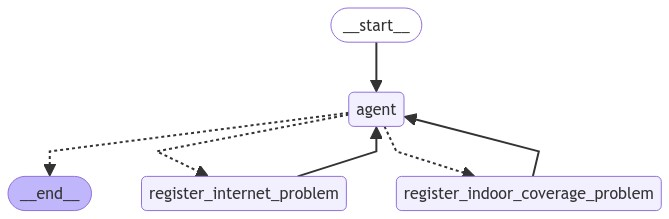

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
import time

In [ ]:
start_time = time.time()
t_flag = 0
inputs = [HumanMessage(content="আমি সকাল ১০ টার পর থেকে ইন্টারনেট সমস্যায় ভুগছি। সমস্যাটা রেজিস্টার করেন।")]
full_message = ""
async for event in app.astream_events({"messages": inputs}, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI or Anthropic usually means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            now_time = time.time() - start_time
            if len(full_message) > 100:
              if t_flag >= 1 and t_flag <= 10:
                print(content+f" \033[91m{now_time:.3f}\033[0m ", end="")
                t_flag += 1
              else:
                print(content, end="")
            else:
              print(content+f" \033[91m{now_time:.3f}\033[0m ", end="")
            full_message += content
            start_time = time.time()
    elif kind == "on_tool_start":
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
        print("--"*50)

    elif kind == "on_tool_end":
        print("\n\n"+"--"*50)
        print(f"Done tool: {event['name']}")
        now_tool_time = time.time() - start_time
        print(f"Tool output was: {event['data'].get('output')}")
        t_flag = 1

Starting tool: register_internet_problem with inputs: {'time': 'সকাল ১০ টা'}
----------------------------------------------------------------------------------------------------
To 0.965  register 0.024  an 0.003  internet 0.015  problem 0.004 , 0.050  you 0.003  typically 0.022  need 0.003  to 0.018  contact 0.003  your 0.018  internet 0.003  service 0.020  provider 0.003  ( 0.034 ISP 0.003 ). 0.018  Here 0.003  are some steps you can follow to report your issue:

### Steps to Register an Internet Problem

1. **Check for Local Outages:**
   - Before contacting your ISP, check if there is a known outage in your area. Many ISPs have a service status page on their website.

2. **Gather Information:**
   - Note down any error messages you are seeing.
   - Check if the problem is affecting all devices or just one.
   - Restart your modem and router to see if the issue resolves itself.

3. **Contact Your ISP:**
   - **Customer Service Phone Number:** Call the customer service or technical s